In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from keras.models import Sequential
from keras.applications import VGG16, VGG19, Xception, ResNet50, MobileNetV2, DenseNet121
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-26 15:50:57.268899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 15:50:57.268998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 15:50:57.405900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [2]:
def load_data(directory, target_size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            try:
                img = Image.open(img_path)
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(label)
            except Exception as e:
                print("Không thể đọc hình ảnh {}: {}".format(img_path, str(e)))
                
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [3]:
# Đường dẫn tới thư mục chứa dữ liệu train, val và test
val_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'
train_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test'

# Load dữ liệu từ thư mục train và test
val_images, val_labels = load_data(val_dir)
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

# Normalize pixel values
val_images = val_images / 255.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# Displaying sample images

In [4]:
def show_images(images, labels, title):
    classes = np.unique(labels)
    samples_per_class = 5
    random_images = []
    random_labels = []

    for cls in classes:
        cls_indices = np.where(labels == cls)[0]
        random_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
        random_images.extend(images[random_indices])
        random_labels.extend(labels[random_indices])

    random_images = np.array(random_images)
    random_labels = np.array(random_labels)

    plt.figure(figsize=(15, 8))
    for i in range(len(random_images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(random_images[i])
        plt.title(random_labels[i])
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

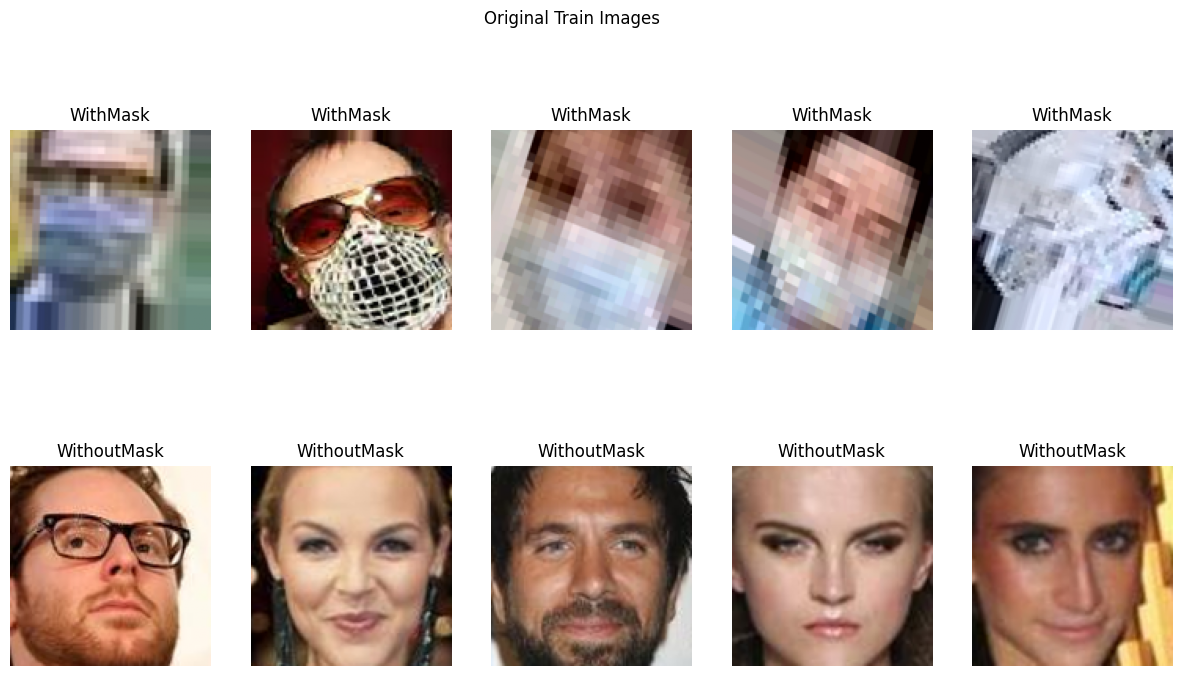

In [5]:
show_images(train_images, train_labels, title="Original Train Images")

# Data augmentation

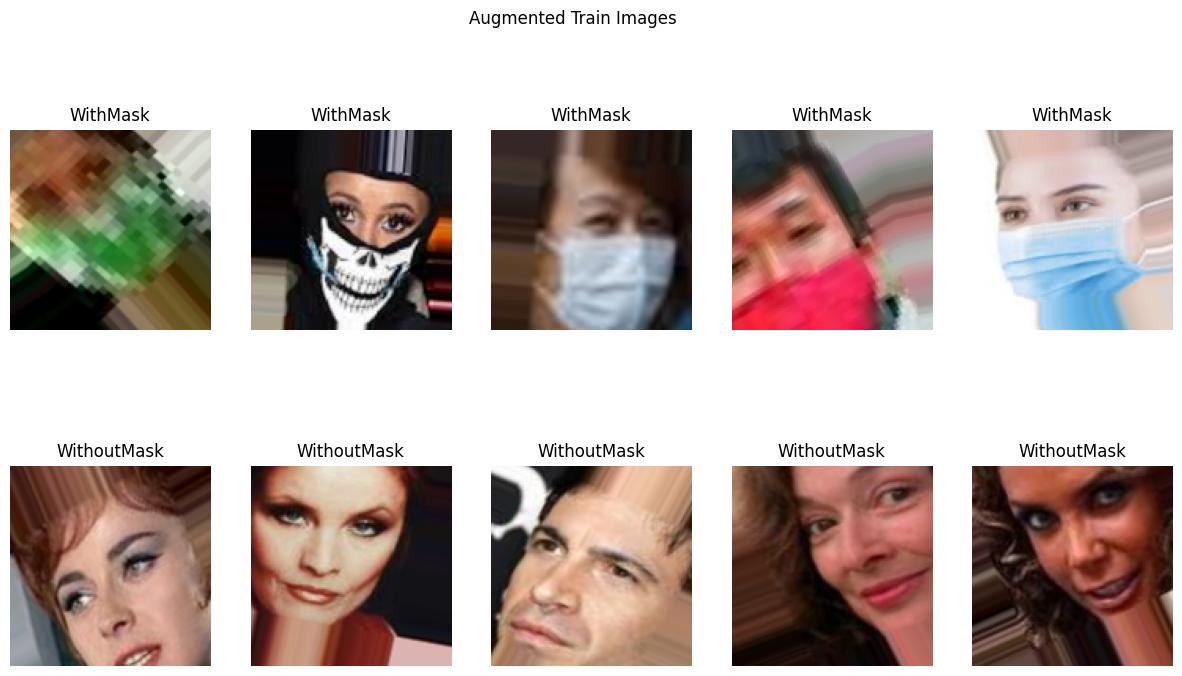

In [6]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
augmented_labels = []

augment_count = 1000
indices = np.random.choice(len(train_images), augment_count, replace=False)

for i in indices:
    img = train_images[i].reshape((1,) + train_images[i].shape)
    label = train_labels[i]
    aug_iter = datagen.flow(img, batch_size=1)
    aug_img = next(aug_iter)[0].astype('float32')
    augmented_images.append(aug_img)
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

show_images(augmented_images, augmented_labels, title="Augmented Train Images")

# Distribution of data

In [7]:
def plot_combined_class_distribution(train_labels, val_labels, test_labels, augmented_labels):
    
    train_counts = pd.Series(train_labels).value_counts().sort_index()
    val_counts = pd.Series(val_labels).value_counts().sort_index()
    test_counts = pd.Series(test_labels).value_counts().sort_index()
    augmented_counts = pd.Series(augmented_labels).value_counts().sort_index()

    class_counts = pd.DataFrame({
        'Train': train_counts,
        'Validation': val_counts,
        'Test': test_counts,
        'Augmented Train': augmented_counts
    }).fillna(0).astype(int)

    ax = class_counts.plot(kind='bar', figsize=(15, 8), width=0.8)
    plt.title('Distribution of data')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=0)
    plt.legend(loc='best')
    
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

    plt.show()

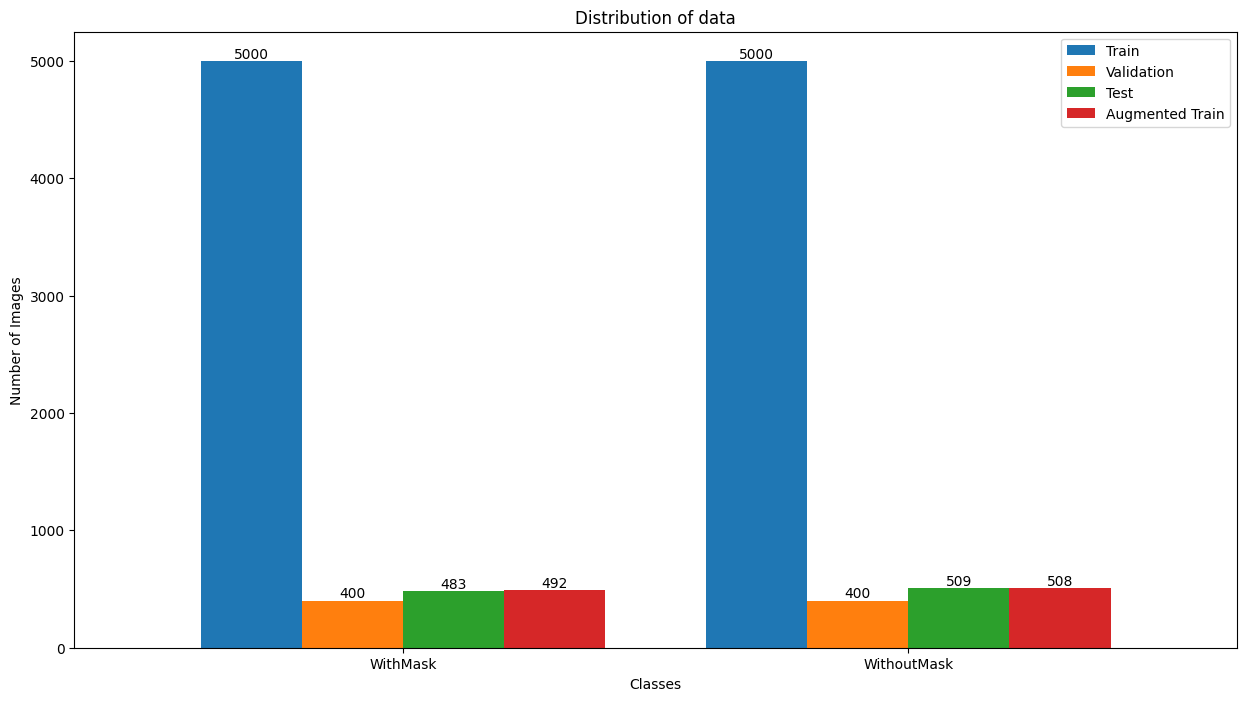

In [8]:
plot_combined_class_distribution(train_labels, val_labels, test_labels, augmented_labels)

# Model performance comparison

In [9]:
def preprocess_labels(labels, num_classes):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)
    return labels_one_hot

In [10]:
train_images_augmented = np.concatenate((train_images, augmented_images), axis=0)
train_labels_augmented = np.concatenate((train_labels, augmented_labels), axis=0)

train_labels_augmented_one_hot = preprocess_labels(train_labels_augmented, num_classes=2)
val_labels_one_hot = preprocess_labels(val_labels, num_classes=2)

In [11]:
model_histories = []

# Define model names
names = ['VGG16', 'VGG19', 'Xception', 'ResNet50', 'MobileNetV2', 'DenseNet121']

# Training models with pre-trained architectures
pretrained_models = [VGG16(include_top=False, input_shape=(128, 128, 3)),
                     VGG19(include_top=False, input_shape=(128, 128, 3)),
                     Xception(include_top=False, input_shape=(128, 128, 3)),
                     ResNet50(include_top=False, input_shape=(128, 128, 3)),
                     MobileNetV2(include_top=False, input_shape=(128, 128, 3)),
                     DenseNet121(include_top=False, input_shape=(128, 128, 3))]

for model, name in zip(pretrained_models, names):
    for layer in model.layers:
        layer.trainable = False

    my_model = Sequential([
        model,
        Flatten(),
        Dense(2, activation='sigmoid')
    ])
    
    model.summary()
    
    my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_history = my_model.fit(x=train_images_augmented, y=train_labels_augmented_one_hot,
                                 validation_data=(val_images, val_labels_one_hot), epochs=10)
    model_histories.append(model_history)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


2024-05-26 15:53:04.923613: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-05-26 15:53:04.923675: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-05-26 15:53:04.923689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-05-26 15:53:04.923702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-05-26 15:53:04.923722: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-05-26 15:53:04.923733: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-05-26 15:53:04.923756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-05-26 15:53:04.923768: E external/local_xla/xla/ser

  6/344 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6748 - loss: 0.6288

I0000 00:00:1716738791.543158      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716738791.564499      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


342/344 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9512 - loss: 0.1472

2024-05-26 15:53:19.848776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 3.48173, expected 2.8998
2024-05-26 15:53:19.848841: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.67833, expected 3.09641
2024-05-26 15:53:19.848850: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.15397, expected 2.57204
2024-05-26 15:53:19.848858: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.74115, expected 4.15923
2024-05-26 15:53:19.848866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.64221, expected 4.06029
2024-05-26 15:53:19.848874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.48702, expected 3.9051
2024-05-26 15:53:19.848881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 4.33308, expected 3.75115
2024-05-26 15:53:19.848889: E external/local_xla/xla/

344/344 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9515 - loss: 0.1466 - val_accuracy: 0.9937 - val_loss: 0.0304
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9823 - loss: 0.0509 - val_accuracy: 0.9937 - val_loss: 0.0275
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9891 - loss: 0.0335 - val_accuracy: 0.9962 - val_loss: 0.0123
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9964 - loss: 0.0176 - val_accuracy: 0.9975 - val_loss: 0.0093
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9957 - loss: 0.0170 - val_accuracy: 0.9987 - val_loss: 0.0088
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9970 - loss: 0.0137 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9987 - loss: 0.0094 - val_accuracy: 0.9987 - val_loss: 0.0068
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9994 - loss: 0.0068 - val_accuracy: 0.9

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10
  7/344 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5639 - loss: 0.7408 

W0000 00:00:1716738892.623023      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


344/344 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9138 - loss: 0.2228 - val_accuracy: 0.9450 - val_loss: 0.1283
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9600 - loss: 0.1137 - val_accuracy: 0.9875 - val_loss: 0.0436
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9860 - loss: 0.0460 - val_accuracy: 0.9912 - val_loss: 0.0396
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9889 - loss: 0.0434 - val_accuracy: 0.9937 - val_loss: 0.0342
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9930 - loss: 0.0310 - val_accuracy: 0.9825 - val_loss: 0.0378
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9896 - loss: 0.0348 - val_accuracy: 0.9862 - val_loss: 0.0432
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9855 - loss: 0.0423 - val_accuracy: 0.9800 - val_loss: 0.0522
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9933 - loss: 0.0237 - val_accurac

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.9759 - loss: 0.0767 - val_accuracy: 0.9950 - val_loss: 0.0404
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9971 - loss: 0.0153 - val_accuracy: 0.9962 - val_loss: 0.0216
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9962 - loss: 0.0202 - val_accuracy: 0.9962 - val_loss: 0.0294
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9986 - loss: 0.0097 - val_accuracy: 0.9987 - val_loss: 0.0414
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9994 - loss: 0.0097 - val_accuracy: 0.9962 - val_loss: 0.0286
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.9975 - val_loss: 0.0239
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9975 - val_loss: 0.0284
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 1.0000 - loss: 1.1008e-0

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.6657 - loss: 0.6260 - val_accuracy: 0.7900 - val_loss: 0.4812
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8273 - loss: 0.4522 - val_accuracy: 0.8625 - val_loss: 0.4089
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8617 - loss: 0.3817 - val_accuracy: 0.8913 - val_loss: 0.3434
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8723 - loss: 0.3445 - val_accuracy: 0.9013 - val_loss: 0.3238
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8781 - loss: 0.3239 - val_accuracy: 0.9237 - val_loss: 0.2886
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8900 - loss: 0.3014 - val_accuracy: 0.9175 - val_loss: 0.2727
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8872 - loss: 0.2932 - val_accuracy: 0.9187 - val_loss: 0.2613
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8964 - loss: 0.2852 - val_acc

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9644 - loss: 0.1178 - val_accuracy: 0.9987 - val_loss: 0.0092
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9982 - loss: 0.0086 - val_accuracy: 0.9975 - val_loss: 0.0086
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9987 - val_loss: 0.0074
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9987 - val_loss: 0.0082
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 8.3528e-04 - val_accuracy: 0.9987 - val_loss: 0.0053
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 1.1207e-04 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 3.5500e-05 - val_accuracy: 0.9987 - val_loss: 0.0042
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 2.82

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.9762 - loss: 0.0706 - val_accuracy: 0.9975 - val_loss: 0.0170
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9976 - loss: 0.0109 - val_accuracy: 0.9975 - val_loss: 0.0130
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9983 - loss: 0.0117 - val_accuracy: 0.9975 - val_loss: 0.0060
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9994 - loss: 0.0071 - val_accuracy: 0.9987 - val_loss: 0.0057
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9987 - val_loss: 0.0049
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 1.0000 - loss: 5.4938e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 1.0000 - loss: 2.4807e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9999 - loss: 0.0026 

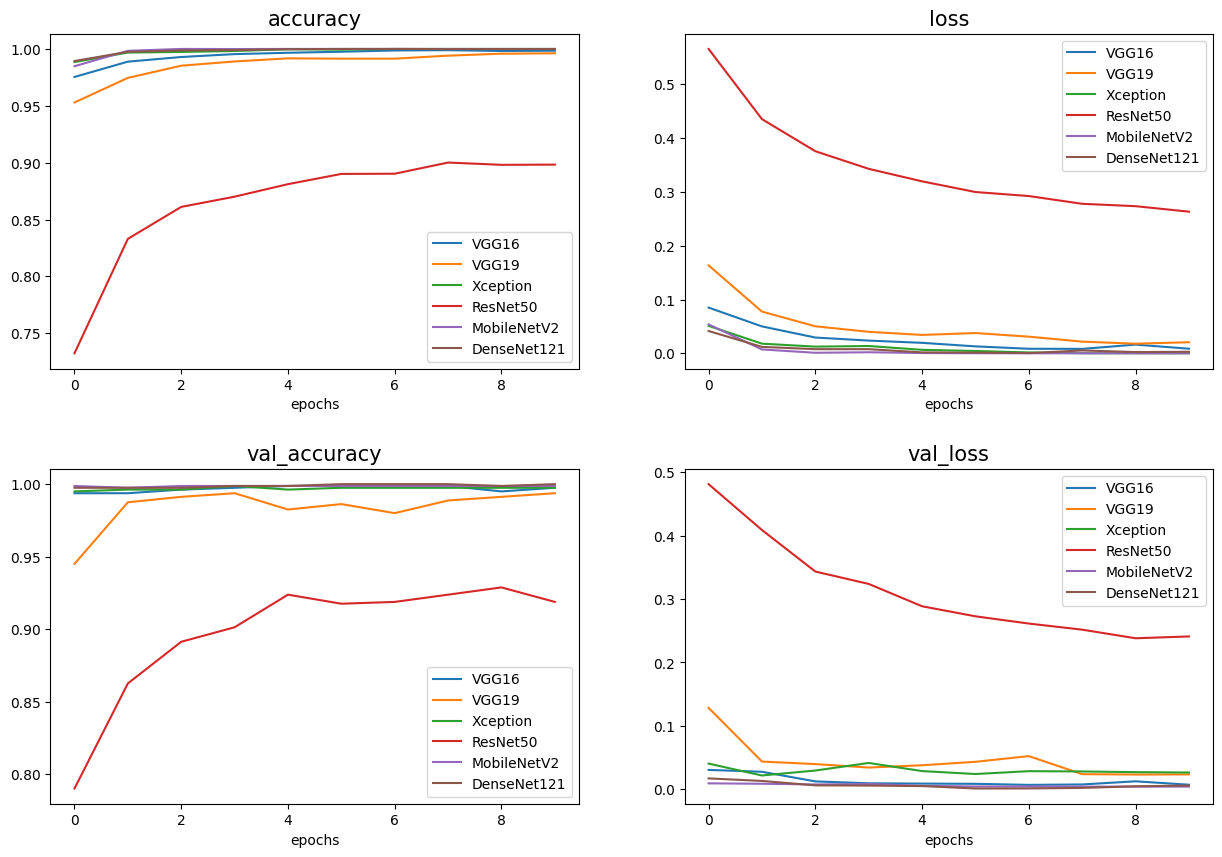

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)

for i, metric in enumerate(model_histories[0].history):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    for history, name in zip(model_histories, names):
        ax.plot(history.history[metric], label=name)
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.legend()

plt.show()

In [13]:
test_labels = preprocess_labels(test_labels, num_classes=2)

In [14]:
test_accuracies = []

# Evaluate custom architecture model
custom_model = model_histories[0].model
_, custom_accuracy = custom_model.evaluate(test_images, test_labels)
test_accuracies.append(custom_accuracy)

# Evaluate functional models
for model_history, name in zip(model_histories[1:], names):
    model = model_history.model
    _, accuracy = model.evaluate(test_images, test_labels)
    test_accuracies.append(accuracy)

# Print the test accuracies
for name, accuracy in zip(names, test_accuracies):
    print(f"{name}: Test Accuracy = {accuracy}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9946 - loss: 0.0176
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9922 - loss: 0.0157
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9964 - loss: 0.0150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9641 - loss: 0.1467
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9972 - loss: 0.0152
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9990 - loss: 0.0185
VGG16: Test Accuracy = 0.9959677457809448
VGG19: Test Accuracy = 0.9868951439857483
Xception: Test Accuracy = 0.9979838728904724
ResNet50: Test Accuracy = 0.9264112710952759
MobileNetV2: Test Accuracy = 0.9969757795333862
DenseNet121: Test Accuracy = 0.9979838728904724


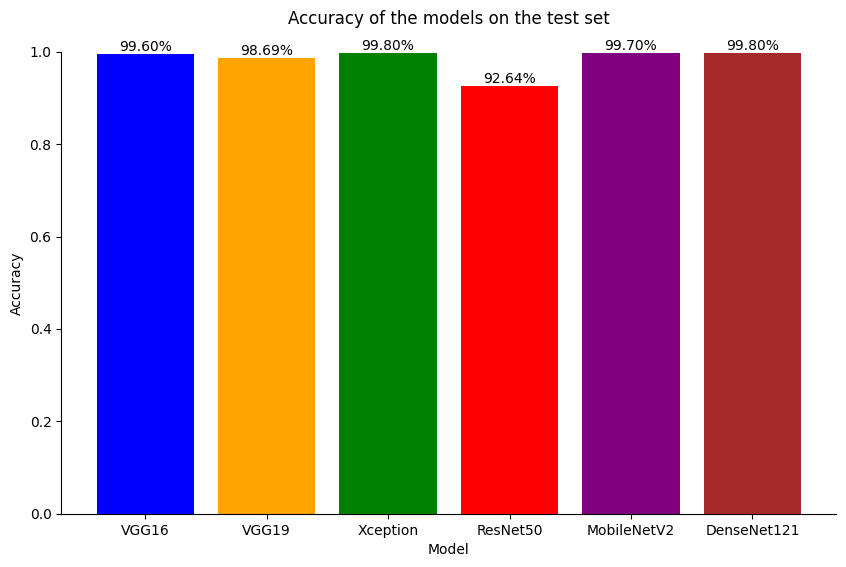

In [15]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Plotting the test accuracies
plt.figure(figsize=(10, 6))  # Kích thước lớn hơn cho biểu đồ
bars = plt.bar(names, test_accuracies, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval*100:.2f}%', va='bottom', ha='center', color='black')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Accuracy of the models on the test set', pad=20)
plt.show()